*******q1 part 1********
*******1000 units, dropout prob = 0.5 ********
init layer [1000, 10]
self.learningrate =  0.005
Final test err 0.0939794 9
Final valid err 0.09 4
$$$$$$$$$$$$$$$ in plot fig$$$$$$$$$$$$$$$$$
(2, 10)


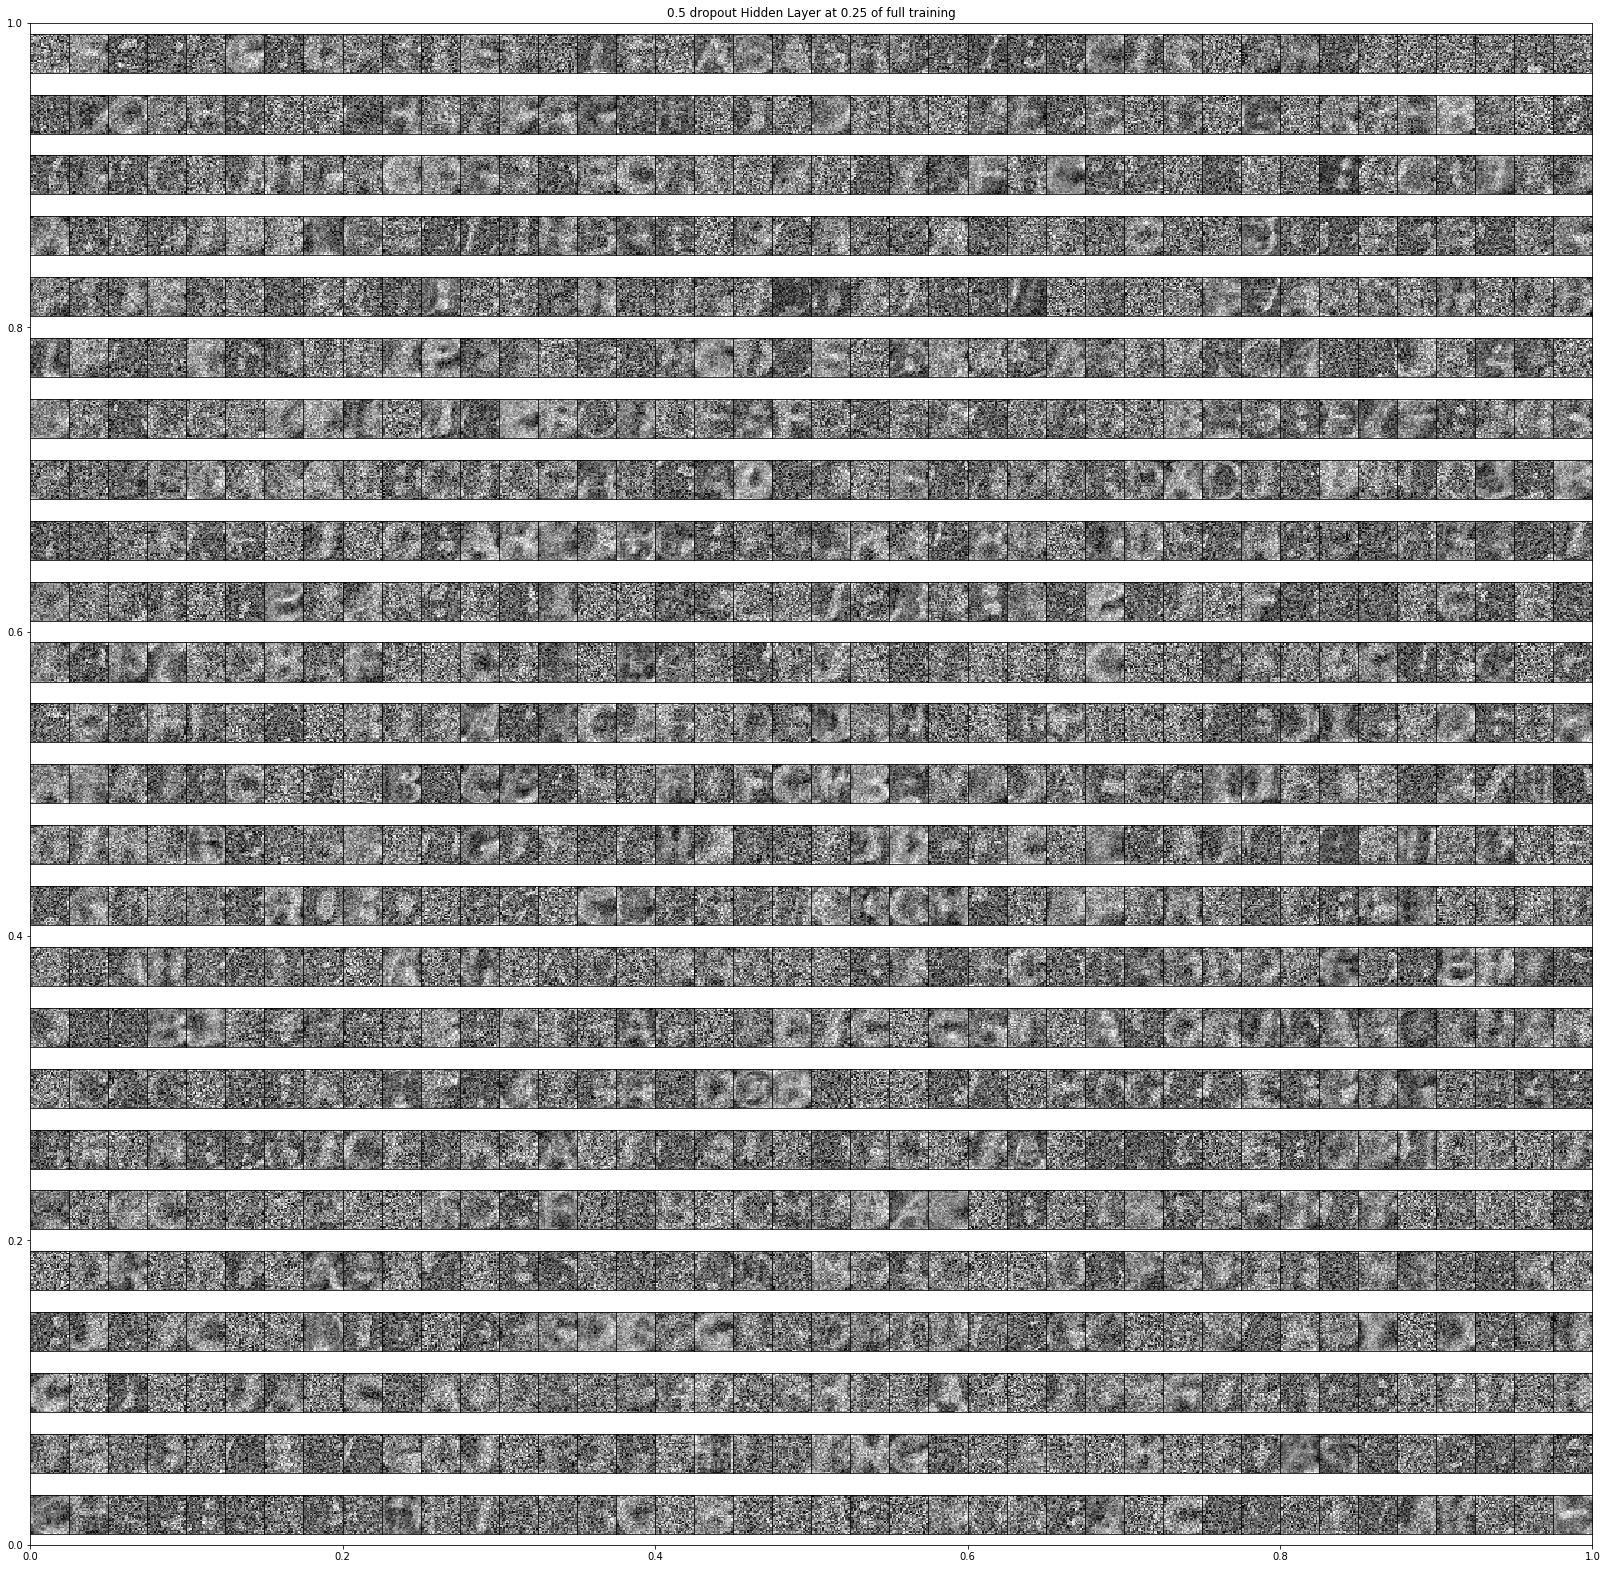

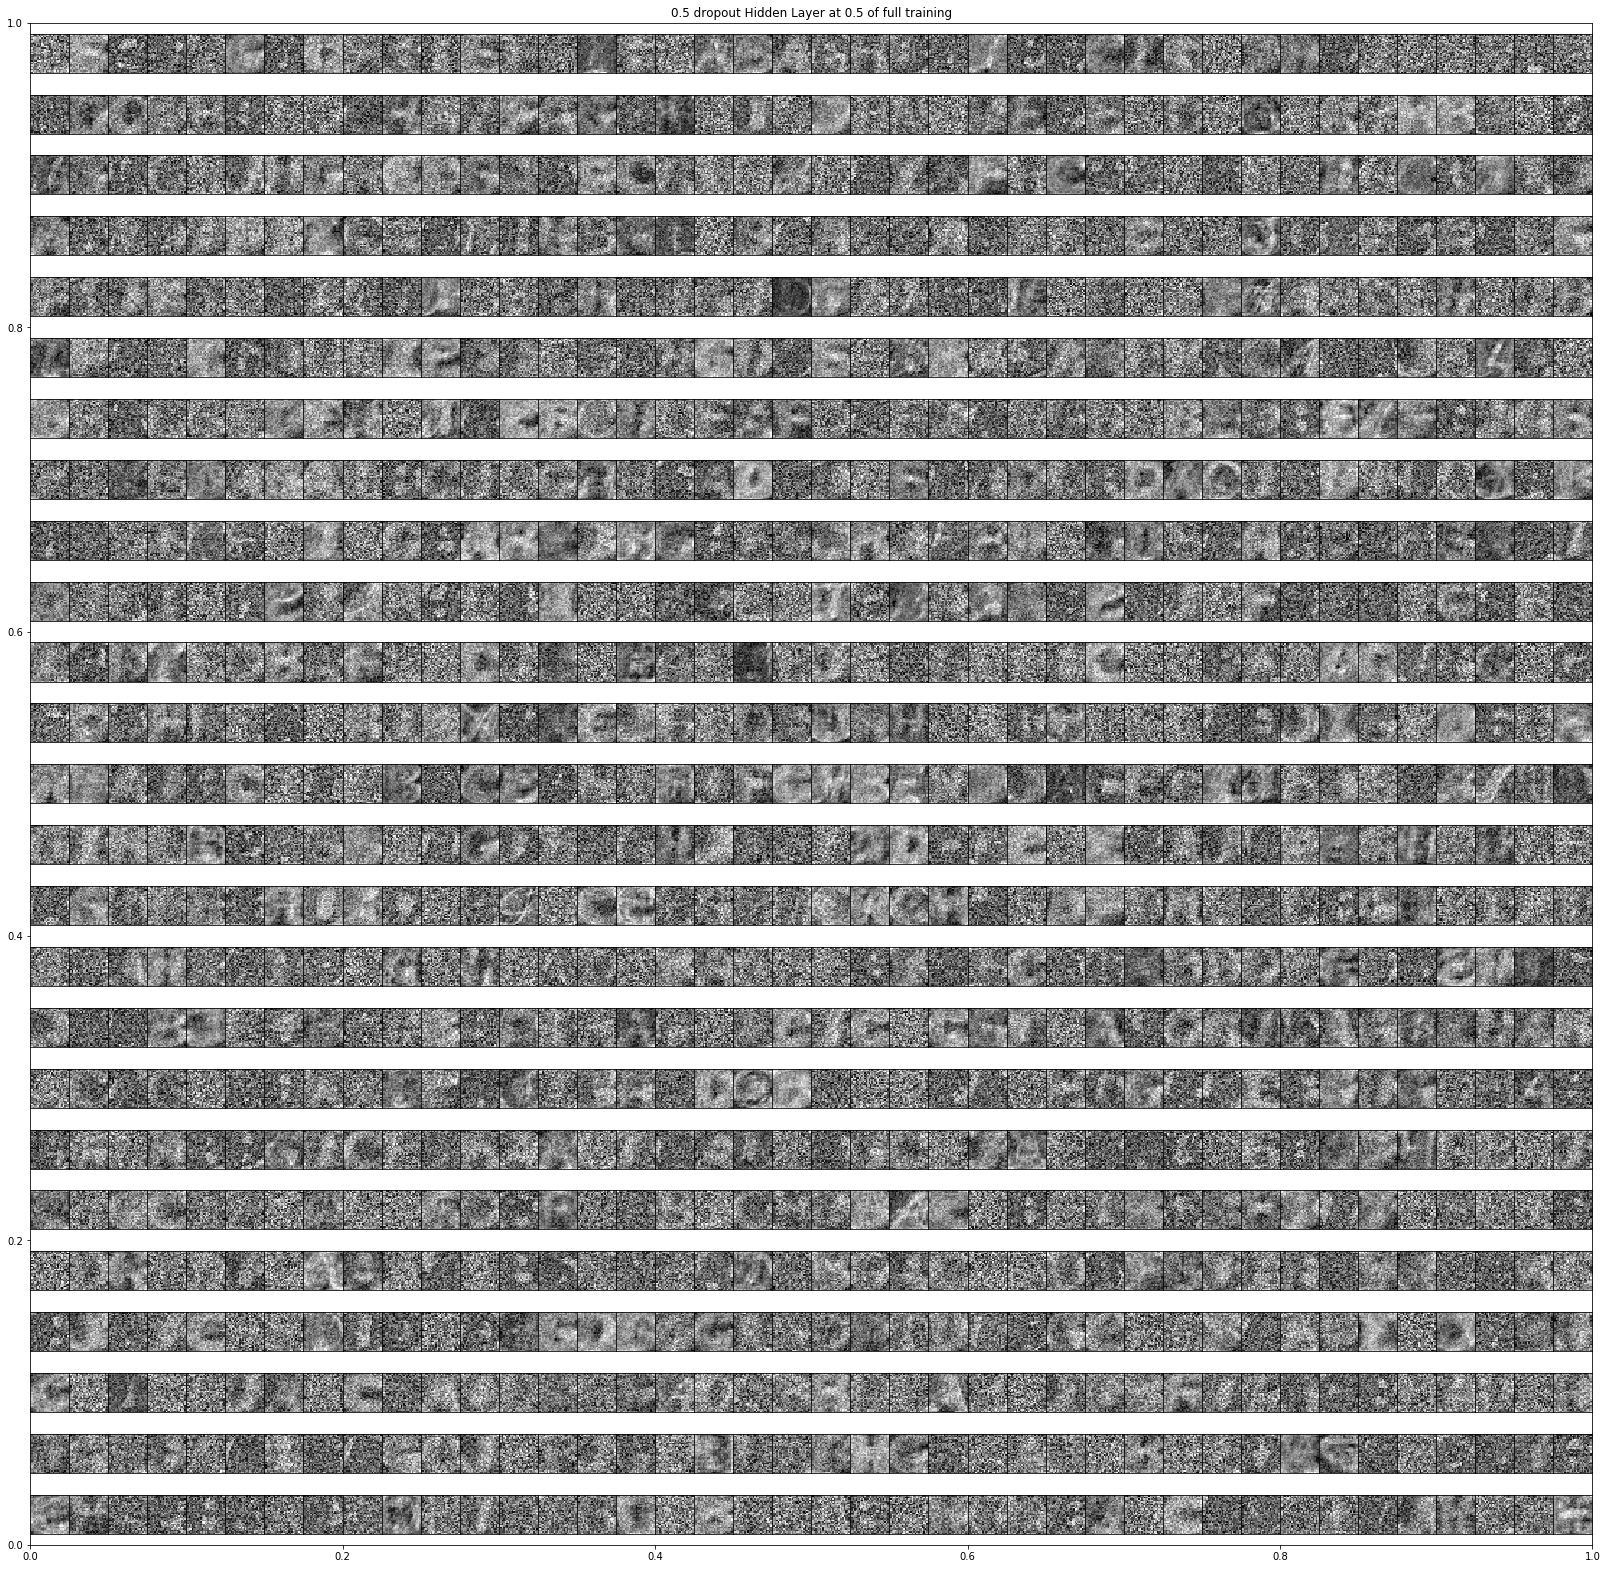

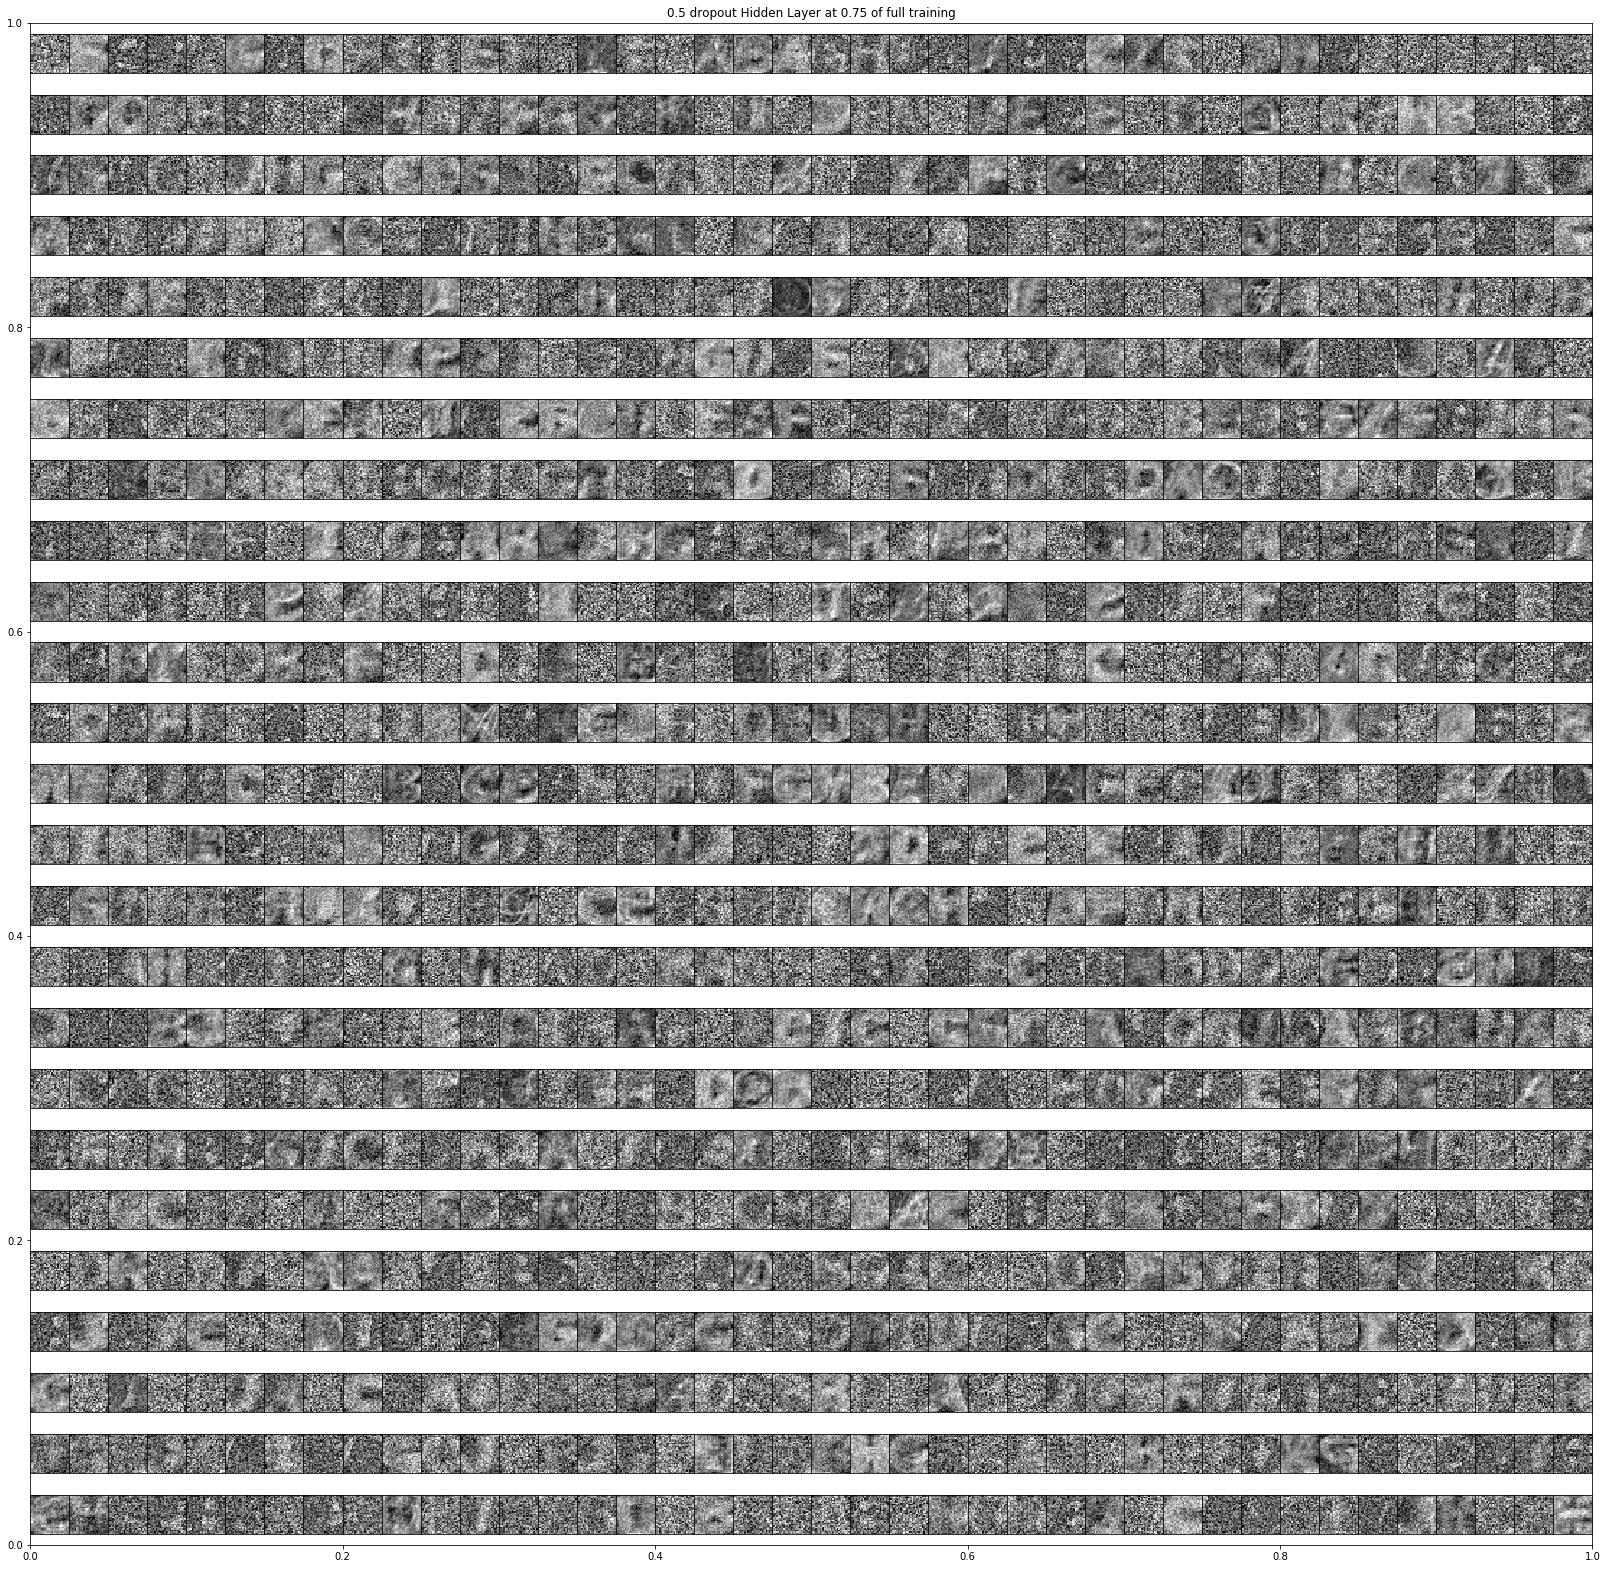

In [24]:
import tensorflow as tf
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import math


def hyperParamGen():
    #random sampes using numpy
    logLearningRate = np.random.uniform(-7.5, -4.5)
    print("logLearningRate", logLearningRate)
    learningRate = np.exp(logLearningRate)
    print("learningRate", learningRate)
    numLayers = np.random.random_integers(1, 5)
    print("numLayers", numLayers)
    numHiddenUnits = np.random.random_integers(100, 500)
    print("numHiddenUnits", numHiddenUnits)
    logWeightedDecay = np.random.uniform(-9, -6)
    print("logWeightedDecay", logWeightedDecay)
    weightedDecay = np.exp(logWeightedDecay)
    print("weightedDecay", weightedDecay)
    dropOut = np.random.random_integers(0, 1) # 0 or 1
    print("dropOut", dropOut)
    
    return learningRate, numLayers, numHiddenUnits, weightedDecay, dropOut

def convertTarget(targetValues):
    numClasses = np.max(targetValues) + 1
    return np.eye(numClasses)[targetValues]

class loadData:
    def __init__(self):
        self.flatten = True
        self.addOnes = False
        
        self.data_path = '/Users/vikuo/Documents/GitHub/ece521/assi/A3/notMNIST.npz'
    def arrFlatten(self, arr):
        '''
        type np array
        '''
        dataDim1, dum1, dum2 = arr.shape
        dum_sq = dum1 * dum2
        arr = np.reshape(arr, [ dataDim1 ,dum_sq ])
        return arr   
    '''
    def convertTarget(self, targetValues):
        numClasses = np.max(targetValues) + 1
        return np.eye(numClasses)[targetValues]
    '''
    def loadNumData(self):
        with np.load(self.data_path) as data:
            Data, Target = data ["images"], data["labels"]
            np.random.seed(521)
            randIndx = np.arange(len(Data))
            np.random.shuffle(randIndx)
            Data = Data[randIndx]/255.
            
            if self.flatten:
                Data = self.arrFlatten(Data)
            
            Target = Target[randIndx]
            trainData, trainTarget = Data[:15000], Target[:15000]
            validData, validTarget = Data[15000:16000], Target[15000:16000]
            testData, testTarget = Data[16000:], Target[16000:]
            
            trainTarget = convertTarget(trainTarget)
            validTarget = convertTarget(validTarget)
            testTarget = convertTarget(testTarget)
 
        return trainData, trainTarget, validData, validTarget, testData, testTarget

class BatchSampler(object):
    '''
    A (very) simple wrapper to randomly sample batches without replacement.
    '''
    
    def __init__(self, data, targets, batch_size):
        self.num_points = data.shape[0]
        self.features = data.shape[1]
        self.data = data
        self.targets = targets
        self.batch_size = batch_size
        self.indices = np.arange(self.num_points)

    def random_batch_indices(self, m=None):
        if m is None:
            indices = np.random.choice(self.indices, self.batch_size, replace=False)
        else:
            indices = np.random.choice(self.indices, m, replace=False)
        return indices 

    def get_batch(self, m=None):
        '''
        Get a random batch without replacement from the dataset.
        If m is given the batch will be of size m. 
        Otherwise will default to the class initialized value.
        '''
        indices = self.random_batch_indices(m)
        X_batch = np.take(self.data, indices, 0)
        y_batch = self.targets[indices]
        return X_batch, y_batch


class neuralNetwork:
    # these are for testing only
    def __init__(self, _learningRate = 0.005, _learningRateArr = [0.05], 
                 _numLayers = [1000], _weightedDecay = 3e-4, _dropOut = 0, _epochIter = 20):
        # learningRate, numLayers, numHiddenUnits, weightedDecay, dropOut
        self.learningRate = _learningRate
        self.learningRateArr = _learningRateArr
        self.numLayers = _numLayers # number of units in each layer
        self.numLayers.append(10)
        print("init layer", self.numLayers)
        self.weightedDecay = _weightedDecay
        self.dropOut = _dropOut
        self.dropOutProb = 0.5
        self.epochIter = _epochIter 
        
        
        # default, no arg taken
        self.numPixel = 784 
        self.numClass = 10
        self.batchSize = 500
        
    def buildLayer(self, _inputTensor, _numUnits):
        '''
        input:
            #feed# _inputTensor S = theta(Xprev)from the prev layer
            _numUnits is the num of neurons in this layer
    
        intermediate xavierInit:
            W is initialized as Xavier
            W is input.shape[1] by num units
    
        output:
        weighted sum of inputs
    
        '''
        # zero mean independent Gaussians whose variance is 3/(#input + #outputs)  
        dim1 = _inputTensor.get_shape().as_list()[1]
        

        
        #Xavier
        #W = tf.get_variable("W", shape = [dim1, _numUnits], initializer=tf.contrib.layers.xavier_initializer())
        variance = 3.0 / (dim1 + _numUnits)
        weight = tf.Variable(tf.truncated_normal(shape = [dim1, _numUnits],  stddev = math.sqrt(variance)))
        #b = tf.Variable(0.0, name='biases')
        b = tf.Variable(tf.zeros([_numUnits]), name = 'biases')

        
        #print("W", dim1, _numUnits)
        #print("X shape", _inputTensor.get_shape().as_list())
        X = tf.matmul(tf.cast(_inputTensor, dtype = tf.float32), weight) + b
    
        #X = tf.add(X, b)
        #print("X in layer", X)
        regTerm = tf.multiply( tf.constant(0.50, dtype = tf.float32),\
                        tf.multiply(tf.constant(self.weightedDecay,dtype = tf.float32), tf.reduce_mean(tf.square(weight))))
        
        tf.add_to_collection("weight", weight)
        tf.add_to_collection("regTerm", regTerm)

        return X
    
    
        
        
    def accuracy(self, y_hat, target):
        #TAKEN FROM last assignment
        
        target = tf.cast(target, dtype = tf.float32)
        correctCases = tf.equal(tf.argmax(y_hat, 1), tf.argmax(target, 1))
        accuracy = tf.reduce_mean(tf.cast(correctCases, dtype="float"))
        return accuracy #.eval()
    
    def classificationError(self, y_hat, target):
        target = tf.cast(target, dtype = tf.float32)
        correctCases = tf.equal(tf.argmax(y_hat, 1), tf.argmax(target, 1))
        
        error = 1 - tf.reduce_mean(tf.cast(correctCases, dtype="float"))
        return error

    
    def buildNet(self):
        '''
        input: 
            number of hidden units #in the class def
            data #feed
        output:
            predicted labels
        '''
                
        X = tf.placeholder(tf.float32, shape=[None, self.numPixel], name='dataX')
        y_target = tf.placeholder(tf.float32, shape=[None, self.numClass], name='targetY')

        X_prev = X #tf.convert_to_tensor(X)
        for numUnits in self.numLayers: #numLayers is an array of num hidden units            
            X_curr = self.buildLayer(X_prev, numUnits)
            #print("X_curr", X_curr)
            S_curr = tf.nn.relu(X_curr)
            X_prev = S_curr
            if self.dropOut:
                X_prev = tf.nn.dropout(X_prev, self.dropOutProb)
        
        y_hat = X_curr
        
        crossEntropyErrorCurr = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits = y_hat, labels = y_target))
        
        regTermSum = sum(tf.get_collection("regTerm"))
        regTermSum = tf.cast(regTermSum, dtype = tf.float32)
        #print("regTermsum", regTermSum)
        #print("crossEntropyError Curr", crossEntropyErrorCurr)
        
        totalLoss = tf.add(regTermSum , crossEntropyErrorCurr)
        
        optimizer = tf.train.AdamOptimizer(learning_rate = self.learningRate)
        train = optimizer.minimize(loss=totalLoss)
        accuracyTerm = self.accuracy(y_hat, y_target)
        classErrTerm = self.classificationError(y_hat, y_target)
        W = tf.get_collection("weight")
        
        #return totalLoss also??
        return W, X, y_hat, y_target, crossEntropyErrorCurr, accuracyTerm, classErrTerm, train   #final prediction
    
        
        
        
    def plotFig(self, _dim, y , addInfo, title="default", xLabel="epoch", yLabel="yLabel", plotLabel ="plotLabel", _num =1 ):
        x = np.linspace(0, _dim, num=_dim)
        y = np.array(y)
        print("$$$$$$$$$$$$$$$ in plot fig$$$$$$$$$$$$$$$$$")
        print(y.shape)
        plt.figure(_num)
        plt.title(title)
        plt.xlabel(xLabel)
        plt.ylabel(yLabel)
        for i in range(y.shape[0]):
            #print(y.shape[0])
            #print("x", x)
            #print("y", y[i])
            plt.plot(x, y[i], label = plotLabel + str(addInfo[i]))
        
        plt.legend()
        plt.savefig( title + str(_num) + ".png")
        plt.close()
        plt.clf()
        
    def runPart1_1(self, trainData, trainTarget, validData, validTarget,testData, testTarget, plotBool =0):
        '''
        input: data
                1 learning rate to try
                add another function to loop through other hyperparams
        output:
            classification error plot
            cross entropy loss plot
        '''
        range_list = [0.25, 0.5, 0.75, 1] # save at progress %
       
        trainLossL = []
        trainErrL = []
        validErrL =[]
        validLossL = []
        testErrL = []
        testLossL = []
            
        tf.reset_default_graph()

        W, X, y_hat, y_target, crossEntropyErrorCurr, accuracyTerm, classErrTerm, train = self.buildNet()
            
        init = tf.global_variables_initializer()
        #saver = tf.train.Saver()

        sess = tf.InteractiveSession()
        sess.run(init)
        #initialW = sess.run(W)  
        #print("self.learningrate = ", self.learningRate)
        trainBatchSampler = BatchSampler(trainData, trainTarget, self.batchSize)
        #print("self.epochIter", self.epochIter)

        for currEpoch in range(0, self.epochIter):
            total_batch = int(trainData.shape[0]/self.batchSize)
            for i in range(total_batch):
                dataBatch, targetBatch = trainBatchSampler.get_batch()
                currentW, entropyErrTrain, classErrTrain, y_predict, trainModel = \
                    sess.run([W, crossEntropyErrorCurr, classErrTerm, y_hat, train], feed_dict={X: dataBatch, y_target: targetBatch})
                validLoss, validErr = sess.run([crossEntropyErrorCurr, classErrTerm],feed_dict = {X:validData, y_target: validTarget} )
                testLoss, testErr = sess.run([crossEntropyErrorCurr, classErrTerm],feed_dict = {X: testData, y_target: testTarget})
                                            
            for j in range(len(range_list)):
                if currEpoch == int(range_list[j] * self.epochIter - 1) and (plotBool == 3 or plotBool == 4):
                    #print("currEpoch", currEpoch ,"classErrTerm" , classErrTrain, "errTrain", entropyErrTrain)
                    # plot at 25%, 50%, 75%, 100%
            
                    #saver.save(sess, './my-model', global_step= currEpoch * total_batch) #global step should be currEpoch but whatever
                    if plotBool == 3:
                        plotTitle = "No dropout Hidden Layer at {0} of full training".format(range_list[j])
                    else:
                        plotTitle = "{0} dropout Hidden Layer at {1} of full training".format(self.dropOutProb ,range_list[j])
                    plt.figure()
                    #plt.title("Sampled weights at {0} of full training".format(j))
                    #currentW 784 array by 1000 by 1000
                    fig = plt.figure(figsize=(28,28))
                    numCol = 25
                    numRow = 1000/numCol
                    weightPlt = currentW[0]
                    plt.title(plotTitle)
                    for k in range(1000):
                        currSmallImg = np.reshape(weightPlt[::,k:k+1], (28,28))

                        ax = fig.add_subplot(numCol, numRow, k+1)
                        ax.imshow(currSmallImg, interpolation="nearest", cmap="gray")
                        ax.xaxis.set_visible(False)
                        ax.yaxis.set_visible(False)
                        x0, x1 = ax.get_xlim()
                        y0, y1 = ax.get_ylim()
                        ax.set_aspect(abs(x1-x0)/abs(y1-y0))
                    #logStdOut('Saving all images')
                    plt.savefig(plotTitle +".png")
                    #logStdOut('Saved all images')
                    plt.subplots_adjust(wspace=0, hspace=0)
                    
                        
                        
            # indent for plotting vs iter
            trainLossL.append(entropyErrTrain)
            trainErrL.append(classErrTrain)
            validLossL.append(validLoss)
            validErrL.append(validErr)
            testLossL.append(testLoss)
            testErrL.append(testErr)                
        print("self.learningrate = ", self.learningRate)
        print("Final test err", min(testErrL), testErrL.index(min(testErrL)))
        print("Final valid err", min(validErrL), validErrL.index(min(validErrL)))
                        
                        

                
   
        
        if plotBool == 1:
                 #end for
            #start plotting
            allErr = [trainLossL] + [validLossL] + [testLossL]
        
            #print("allErr ", len(allErr))
            #total_iter = len(trainLossL)
            #self.plotFig(_dim = total_iter, y=allErr , addInfo = [self.learningRate], title="Q1_2ClassificationError vs iteration", xLabel="iteration", yLabel="Classification error", plotLabel ="learningRate", _num =1 )
            self.plotFig(_dim = self.epochIter, y = allErr, addInfo =["train", "valid", "test"],
                     title="Q1_2EntropyError vs epoch", xLabel = "epoch",
                     yLabel ="Entropy error", plotLabel ="learningRate"+str(self.learningRate), _num =1)
        
            allErr = [trainErrL] + [validErrL] + [testErrL]
            self.plotFig(_dim = self.epochIter, y = allErr, addInfo =["train", "valid", "test"],
                     title="Q1_2EntropyError vs epoch", xLabel = "epoch",
                     yLabel ="Classification error", plotLabel ="learningRate"+str(self.learningRate), _num =1)
        
        elif plotBool == 2: #test hidden layers
            allErr = [trainLossL] + [validLossL]
            self.plotFig(_dim = self.epochIter, y = allErr, addInfo =["train", "valid"],
                    title="Q1_2_2 2LayerEntropyError vs epoch", xLabel = "epoch",
                    yLabel ="Classification error", plotLabel ="learningRate"+str(self.learningRate), _num =1)
            
        elif plotBool == 3: #test no dropout 1
            allErr = [trainLossL] + [validLossL]
            self.plotFig(_dim = self.epochIter, y = allErr, addInfo =["train", "valid"],
                    title="Q1_3 No dropout EntropyError vs epoch", xLabel = "epoch",
                    yLabel ="Classification error", plotLabel ="learningRate"+str(self.learningRate), _num =1)
            
            
        elif plotBool == 4: #plot dropout
            allErr = [trainLossL] + [validLossL]
            self.plotFig(_dim = self.epochIter, y = allErr, addInfo =["train", "valid"],
                    title="Q1_3 dropout0.5 EntropyError vs epoch", xLabel = "epoch",
                    yLabel ="Classification error", plotLabel ="learningRate"+str(self.learningRate), _num =1)
         
            
            
    def testLambdas(self, trainData, trainTarget, validData, validTarget,testData, testTarget):
        learningRateArr = [0.001, 0.005, 0.01]
        for i in learningRateArr:
            self.learningRate = i
            self.runPart1_1(trainData, trainTarget, validData, validTarget,testData, testTarget)
        
        
        #sess.close()

    def restoreSaver(self):
        sess=tf.Session()    
        restore_saver = tf.train.import_meta_graph('my-model-25.meta')
        restore_saver.restore(sess,tf.train.latest_checkpoint('./'))
        print("trying tf saver")
        #print(sess.run("classErrTerm:0"))
        #graph = tf.get_default_graph()
        #entropyErrTrain =  graph.get_tensor_by_name("entropyErrTrain:0")
        #classErrTerm
        print(sess.run('classErrTerm:0'))
        sess.close()


    
    




if __name__ == '__main__':  

    dataLoader = loadData()
 
    trainData, trainTarget, validData, validTarget,testData, testTarget = dataLoader.loadNumData()
    
    print("*******q1 part 1********")
    learningRates = [0.005] #for debugging accuracy
    lambdaReg = 3e-4
    #1000 units
    #singleLayerNet = neuralNetwork(_learningRate=learningRates[0], _epochIter = 20)

    #singleLayerNet.testLambdas(trainData, trainTarget, validData, validTarget,testData, testTarget)
    #singleLayerNet.runPart1_1(trainData, trainTarget, validData, validTarget,testData, testTarget, plotBool = 1)
    #singleLayerNet.restoreSaver()
    
    #Q 1.2 number of layers
    '''
    print("******100 units*******")
    singleLayerNet100 = neuralNetwork(_learningRate = 0.005, _learningRateArr = [0.005], 
                 _numLayers = [100], _weightedDecay = 3e-4, _dropOut = 0, _epochIter = 20)
    
    singleLayerNet100.runPart1_1(trainData, trainTarget, validData, validTarget,testData, testTarget)

    print("********500 units********")
    singleLayerNet500 = neuralNetwork(_learningRate = 0.005, _learningRateArr = [0.005], 
                 _numLayers = [500], _weightedDecay = 3e-4, _dropOut = 0, _epochIter = 20)
    
    singleLayerNet500.runPart1_1(trainData, trainTarget, validData, validTarget,testData, testTarget)

    print("*******1000 units ********")
    singleLayerNet1000 = neuralNetwork(_learningRate = 0.005, _learningRateArr = [0.005], 
                 _numLayers = [1000], _weightedDecay = 3e-4, _dropOut = 0, _epochIter = 20)
                      
    singleLayerNet1000.runPart1_1(trainData, trainTarget, validData, validTarget,testData, testTarget)

    print("******500, 500 layers******")
    twoLayerNet500 = neuralNetwork(_learningRate = 0.005, _learningRateArr = [0.005], 
                 _numLayers = [500, 500], _weightedDecay = 3e-4, _dropOut = 0, _epochIter = 10)
    
    twoLayerNet500.runPart1_1(trainData, trainTarget, validData, validTarget,testData, testTarget, plotBool = 2)
    
    
    
    #Q 1.3 Dropout and plots
    print("*******1000 units, dropout prob = 0 ********")
    singleLayerNet1000 = neuralNetwork(_learningRate = 0.005, _learningRateArr = [0.005], 
                 _numLayers = [1000], _weightedDecay = 3e-4, _dropOut = 0, _epochIter = 10)
                      
    singleLayerNet1000.runPart1_1(trainData, trainTarget, validData, validTarget,testData, testTarget, plotBool = 3)
    '''
    print("*******1000 units, dropout prob = 0.5 ********")

    singleLayerNet1000 = neuralNetwork(_learningRate = 0.005, _learningRateArr = [0.005], 
                _numLayers = [1000], _weightedDecay = 3e-4, _dropOut = 0.5, _epochIter = 10)
                      
    singleLayerNet1000.runPart1_1(trainData, trainTarget, validData, validTarget,testData, testTarget, plotBool = 4)


    

In [23]:
a = [[1 , 1], [2, 2,2]]
b = np.array(a)




0.25 dropout Hidden Layer at 0.5 of full training


# TO DO:
~ try other lambdas ~
* currentW [0] (784, 30) currentW [0][1] (30,) currentW [1] (30, 10)

* restore value from meta files, plot for early stopping
    for j in range(len(weight_list)):
        print("Graphing set ", j+1)
        plt.figure()
        plt.title("Sampled weights at {0} of full training".format(Checkpoints[j]))
        for k in range(100):
            ax = plt.subplot(10,10,k + 1)
            w_to_plot = np.reshape(weight_list[j][:,k],(28,28))
            plt.imshow(w_to_plot)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        plt.subplots_adjust(wspace=0, hspace=0)
